Import potrzebnych pakietów wraz z wczytanie zbioru danych

In [1]:
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
warnings.filterwarnings("ignore")

Data=pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv',encoding="ISO-8859-1")

Wyrzucam zmienne nie wnoszące wartości, w tym nazwę pracodawcy - łatwo może się zmienić nazwa firmy, biznesowo nie pasująca zmienna. 

In [2]:
Data=Data.drop(['ID','Employer_Name','LoggedIn'],axis=1)

Analiza danych - zauważamy nierówność klas

In [3]:
Data.Disbursed.mean()

0.01462882096069869

In [4]:
Data.Disbursed.sum()

1273

Podział na zbiór testowy i treningowy

In [5]:
X, y = Data.drop(['Disbursed'],axis=1), Data.Disbursed
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.33)

In [6]:
y_test.sum(),y_train.sum()

(435, 838)

Analiza danych - sprawdzam progi zmiennych datowych, aby stowrzyć zmienną mówiącą o wieku kredytiobiorcy. Dodatkowo tworze dwie wersje zmiennej DTI - Debt to income, powinna byc mocniejsza niż pojedyncze czynniki, nie mniej jednak zostawiam każda zmienną składową.

In [7]:
Data.Lead_Creation_Date.str.slice(-2).min(),Data.Lead_Creation_Date.str.slice(-2).max(), \
Data.DOB.str.slice(-2).min(),Data.DOB.str.slice(-2).max()

('15', '15', '15', '97')

In [8]:
X_train['Age']=2000+X_train['Lead_Creation_Date'].str.slice(-2).astype(int)- \
                1900-X_train['DOB'].str.slice(-2).astype(int)
X_test['Age']=2000+X_test['Lead_Creation_Date'].str.slice(-2).astype(int)- \
                1900-X_test['DOB'].str.slice(-2).astype(int)

X_train['DTI']=(X_train['Existing_EMI']+X_train['EMI_Loan_Submitted'])/X_train['Monthly_Income']
X_test['DTI']=(X_test['Existing_EMI']+X_test['EMI_Loan_Submitted'])/X_test['Monthly_Income']

X_train['DTI2']=X_train['Existing_EMI']/X_train['Monthly_Income']
X_test['DTI2']=X_test['Existing_EMI']/X_test['Monthly_Income']

X_train=X_train.drop(['DOB','Lead_Creation_Date'],axis=1)
X_test=X_test.drop(['DOB','Lead_Creation_Date'],axis=1)

Analize dzielę na dwie części - w pierwszej analizuję zmienne numeryczne.

In [9]:
class ColumnSelectorByType():
    
    def __init__(self,typ):
        self.typ=typ

    def fit(self,X,y=None):
        return self
            
    def transform(self,X):
        return X.select_dtypes(self.typ)

In [10]:
cs=ColumnSelectorByType([np.number])
DataNum=cs.transform(X_train)
variables=pd.DataFrame(DataNum.columns)
variables.columns=['column']
variables=variables.column.unique()

Sprawdzam statystyki zmiennych plus wykresy rozkładów(gęstości).

In [11]:
def desc(DataNum):
    desc=DataNum.describe()
    desc.index=['count','mean','std','min','25%','median','75%','max']
    skew=DataNum.skew()
    desc=desc.T
    desc['skew']=skew
    missing=pd.DataFrame(DataNum.isna().sum())
    missing.columns=["missing"]
    desc=desc.join(missing)
    desc["pr missing"]=desc["missing"]/(desc["missing"]+desc['count'])
    return desc

In [12]:
desc(X_train)

,count,mean,std,min,25%,median,75%,max,skew,missing,pr missing
Monthly_Income,58303.0,63891.873694,2.589115e+06,0.000000,16500.000000,25000.000000,40000.000000,4.445544e+08,146.772557,0,0.000000
Loan_Amount_Applied,58257.0,230754.493829,3.535970e+05,0.000000,0.000000,100000.000000,300000.000000,9.999999e+06,5.607286,46,0.000789
Loan_Tenure_Applied,58257.0,2.138129,2.015950e+00,0.000000,0.000000,2.000000,4.000000,1.000000e+01,0.258207,46,0.000789
Existing_EMI,58257.0,3765.091940,4.813283e+04,0.000000,0.000000,0.000000,3500.000000,1.000000e+07,178.767599,46,0.000789
Var5,58303.0,4.956263,5.661883e+00,0.000000,0.000000,2.000000,11.000000,1.800000e+01,0.761643,0,0.000000
Loan_Amount_Submitted,35126.0,394342.082788,3.084737e+05,50000.000000,200000.000000,300000.000000,500000.000000,3.000000e+06,2.110920,23177,0.397527
Loan_Tenure_Submitted,35126.0,3.893327,1.171273e+00,1.000000,3.000000,4.000000,5.000000,6.000000e+00,-0.849784,23177,0.397527
Interest_Rate,18576.0,19.183245,5.814666e+00,11.990000,15.250000,18.000000,20.000000,3.700000e+01,1.435499,39727,0.681389
Processing_Fee,18374.0,5137.308915,4.748267e+03,200.000000,2000.000000,3955.000000,6250.000000,5.000000e+04,2.693019,39929,0.684853
EMI_Loan_Submitted,18576.0,10994.746307,7.601215e+03,1176.410000,6491.280000,9338.600000,12804.080000,1.447483e+05,2.957623,39727,0.681389


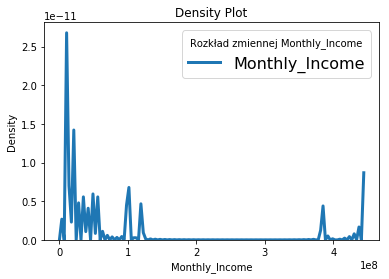

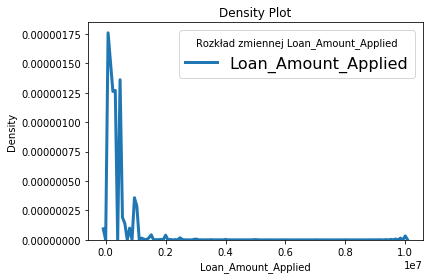

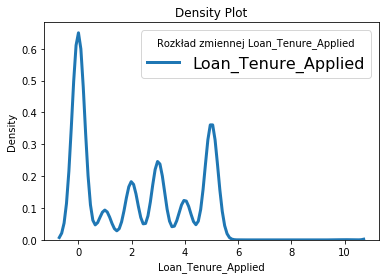

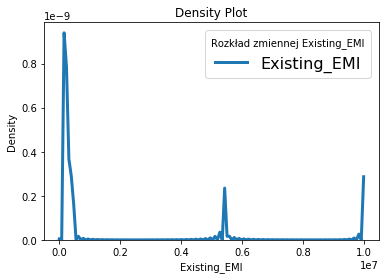

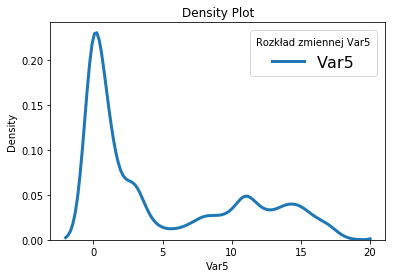

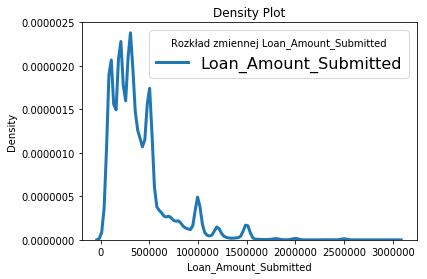

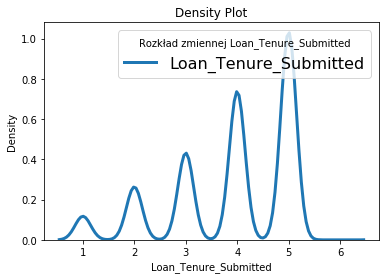

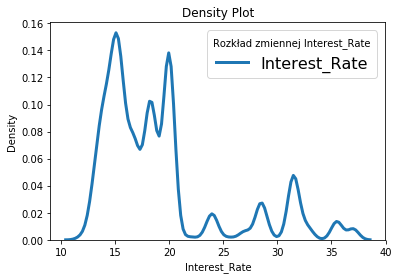

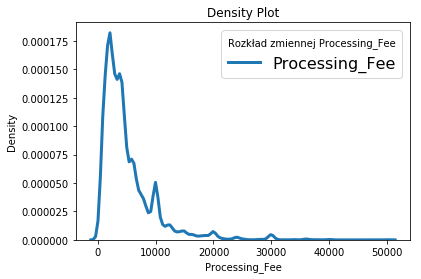

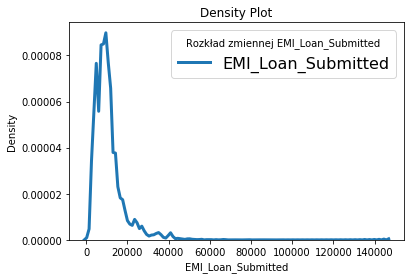

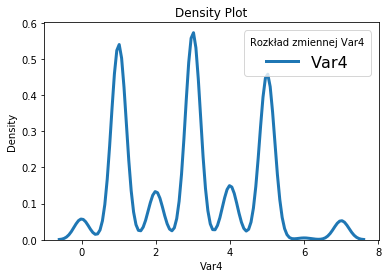

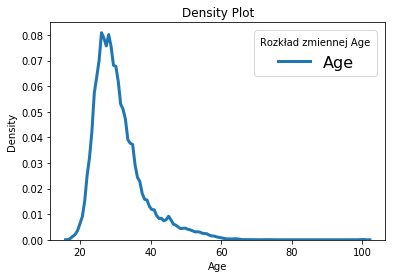

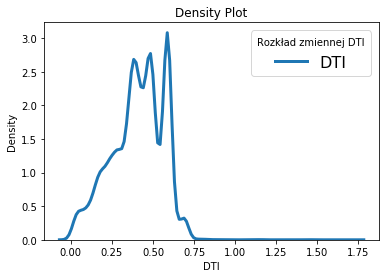

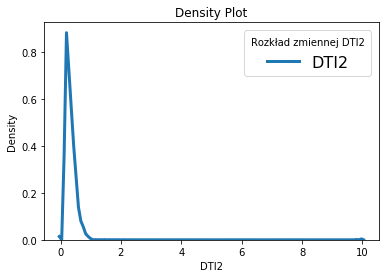

In [13]:
def Plots(X,variables):
    for var in variables:
        sns.distplot(X[var], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},label = var)
        plt.legend(prop={'size': 16}, title = 'Rozkład zmiennej '+var)
        plt.title('Density Plot')
        plt.xlabel(var)
        plt.ylabel('Density')
        plt.show()
Plots(X_train,variables)


DLa wartości 0 w przypadku kwot wnioskowanych oraz tenorów wstawiam missingi - według mnie powinniśmy traktować takie sytuacje jak braki danych.

In [14]:
X_train['Loan_Amount_Applied']=X_train['Loan_Amount_Applied'].replace(0,np.NaN)
X_test['Loan_Amount_Applied']=X_test['Loan_Amount_Applied'].replace(0,np.NaN)
X_train['Loan_Tenure_Applied']=X_train['Loan_Tenure_Applied'].replace(0,np.NaN)
X_test['Loan_Tenure_Applied']=X_test['Loan_Tenure_Applied'].replace(0,np.NaN)

Sprawdzam outliery rozstepem międzykwartylowym. Imputuje outliery granicznymi wartościami.

In [15]:
q1=DataNum.quantile(0.25)
q3=DataNum.quantile(0.75)
iqr=q3-q1

# outliery na podstawie rozstępu międzykwartylowego
low_boundary=(q1-1.5*iqr)
upp_boundary=(q3+1.5*iqr)

std=DataNum.std()
mean=DataNum.mean()


num_of_outliers_L=(DataNum[iqr.index]<low_boundary[iqr.index]).sum()
num_of_outliers_U=(DataNum[iqr.index]>upp_boundary[iqr.index]).sum()

outliersDesc=pd.DataFrame({'low_boundary':low_boundary,'upp_boundary':upp_boundary,'num_of_outliers_L':num_of_outliers_L,'num_of_outliers_U':num_of_outliers_U})


nonMissing=pd.DataFrame(DataNum.count())
nonMissing.columns=["count"]
outliersDesc=outliersDesc.join(nonMissing)
outliersDesc["pr outliers"]=(outliersDesc["num_of_outliers_L"]+outliersDesc["num_of_outliers_U"])/(outliersDesc['count'])

In [16]:
outliersDesc

,low_boundary,upp_boundary,num_of_outliers_L,num_of_outliers_U,count,pr outliers
Monthly_Income,-18750.000000,75250.000000,0,4167,58303,0.071471
Loan_Amount_Applied,-450000.000000,750000.000000,0,3797,58257,0.065177
Loan_Tenure_Applied,-6.000000,10.000000,0,0,58257,0.000000
Existing_EMI,-5250.000000,8750.000000,0,7316,58257,0.125581
Var5,-16.500000,27.500000,0,0,58303,0.000000
Loan_Amount_Submitted,-250000.000000,950000.000000,0,2721,35126,0.077464
Loan_Tenure_Submitted,0.000000,8.000000,0,0,35126,0.000000
Interest_Rate,8.125000,27.125000,0,2655,18576,0.142926
Processing_Fee,-4375.000000,12625.000000,0,1099,18374,0.059813
EMI_Loan_Submitted,-2977.920000,22273.280000,0,1413,18576,0.076066


Missingi postanowiłem zastąpic medianą, 
ale dla kwot wnioskowanych i przyznanych jeszcze przed uzupełnieniem finalnym missingów liczę o ile średnio te 
kwoty się różnią i jeżeli tylko jedna z nich jest uzupełniona to dla drugiej wyliczam wartośc odejmując/dodając średnią różnicę.
Przykładowo: średnio klienci dostają 100 mniej niz wnioskują, wtedy jeżeli uzupełniona jest kwota wnioskowana a przynana
nie to kwotę przyznana uzupełniam przez wartość kwota_wnioskowana-100 i na odwrót.

In [17]:
class Outliers(TransformerMixin,BaseEstimator):
    
    def __init__(self,low_boundary,upp_boundary,variables):
        self.low_boundary=low_boundary
        self.upp_boundary=upp_boundary
        self.variables=variables

    def fit(self,X):
        return self
    
    def transform(self,X):
        for var in variables:
            X.loc[X[var]<low_boundary[var],var]=low_boundary[var]
            X.loc[X[var]>upp_boundary[var],var]=upp_boundary[var]
        return X
    
    
class ImputerLoans(TransformerMixin,BaseEstimator):
    
    def __init__(self,variables):
        self.variables=variables

            
    def fit(self,X):
        self.imput1=(X[self.variables[0]]-X[self.variables[1]]).mean()
        return self
            
    
    def transform(self,X):
        X.loc[np.isnan(X[self.variables[0]]),self.variables[0]]=X[self.variables[1]]+self.imput1
        X.loc[np.isnan(X[self.variables[1]]),self.variables[1]]=X[self.variables[0]]-self.imput1
        return X
    
class ColumnSelector(TransformerMixin,BaseEstimator):
    
    def __init__(self,variables):
        self.variables=variables

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X[self.variables]
    


Tworzę pipeline, którym przekształcam zmienne numeryczne, żeby jeszcze raz sprawdzić ich charakterystyki i rozkłady.

In [18]:
pipeline=make_pipeline(ColumnSelector(variables),
                             Outliers(low_boundary,upp_boundary,variables),
                            ImputerLoans(['Loan_Amount_Applied','Loan_Amount_Submitted']), 
                            SimpleImputer(strategy="median"))

In [19]:
X_train_num=X_train.copy()
X_train_num=pd.DataFrame(pipeline.fit_transform(X_train_num), columns = variables)

In [20]:
desc(X_train_num)

,count,mean,std,min,25%,median,75%,max,skew,missing,pr missing
Monthly_Income,58303.0,30449.467334,19064.421482,0.000000,16500.000000,25000.000000,40000.000000,75250.000000,1.091522,0,0.0
Loan_Amount_Applied,58303.0,338673.669295,213969.751483,2.000000,200000.000000,300000.000000,500000.000000,955397.056110,0.974851,0,0.0
Loan_Tenure_Applied,58303.0,3.301288,1.106717,1.000000,3.000000,3.000000,4.000000,10.000000,0.223022,0,0.0
Existing_EMI,58303.0,1970.582975,3215.464587,0.000000,0.000000,0.000000,3500.000000,8750.000000,1.289469,0,0.0
Var5,58303.0,4.956263,5.661883,0.000000,0.000000,2.000000,11.000000,18.000000,0.761643,0,0.0
Loan_Amount_Submitted,58303.0,333276.613185,224091.988601,-5395.056110,194602.943890,294602.943890,450000.000000,950000.000000,1.192271,0,0.0
Loan_Tenure_Submitted,58303.0,3.935732,0.910625,1.000000,4.000000,4.000000,4.000000,6.000000,-1.228570,0,0.0
Interest_Rate,58303.0,18.168591,2.474906,11.990000,18.000000,18.000000,18.000000,27.125000,1.978438,0,0.0
Processing_Fee,58303.0,4201.835240,1934.014620,200.000000,3955.000000,3955.000000,3955.000000,12625.000000,2.500169,0,0.0
EMI_Loan_Submitted,58303.0,9647.996636,3044.331183,1176.410000,9338.600000,9338.600000,9338.600000,22273.280000,2.007003,0,0.0


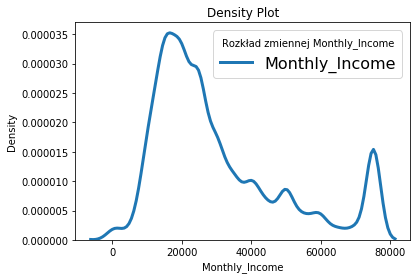

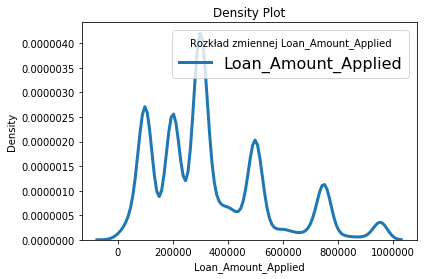

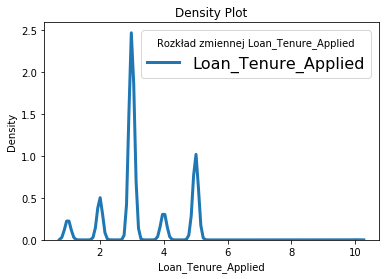

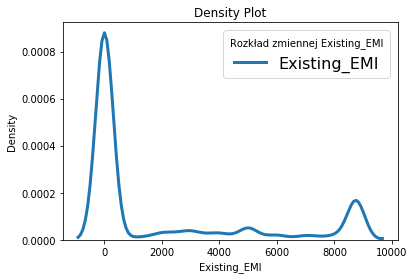

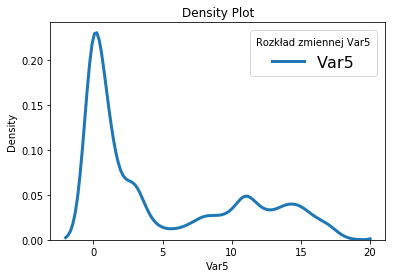

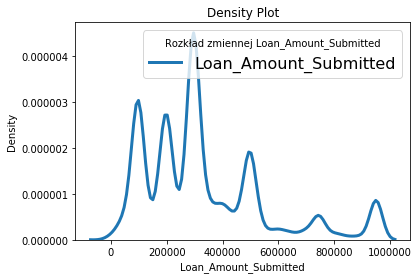

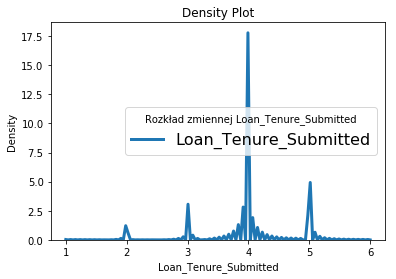

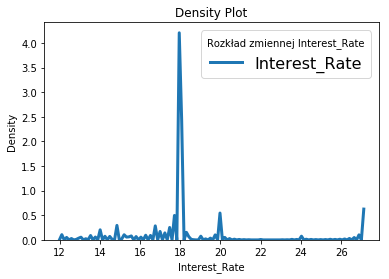

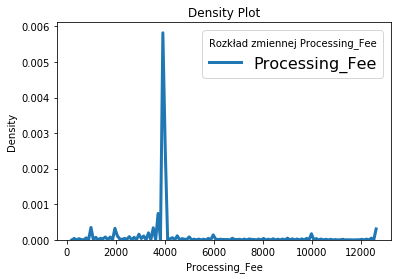

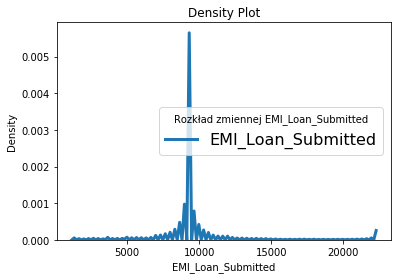

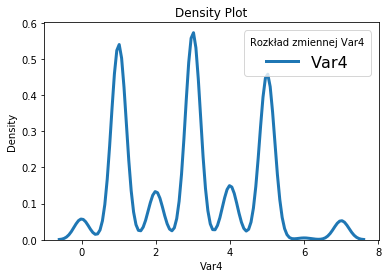

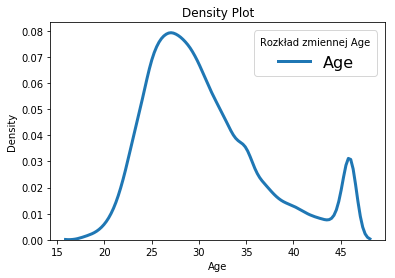

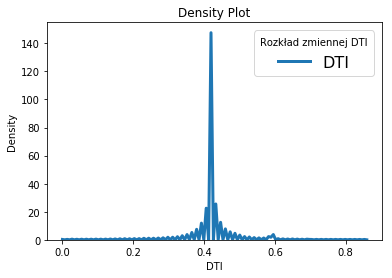

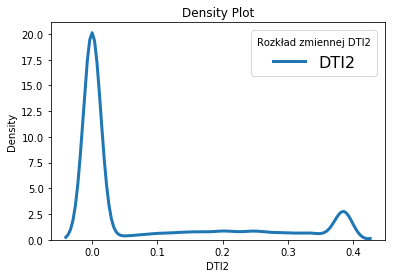

In [21]:
Plots(X_train_num,variables)

Druga część analizy - zmienne tektowe. Sprawdzam rozkłady i tworzę oddzielne kategorie dla wartości mających poniżej 5% częstości wystepowania. Ogólnie dla zmiennych numerycznych jak i tekstowych tj. Var1 czy Source pomimo braku wiedzy co zawierają postanowiłem dołączyć je do modelu.

In [22]:
VariablesStr=X_train.columns.difference(variables)

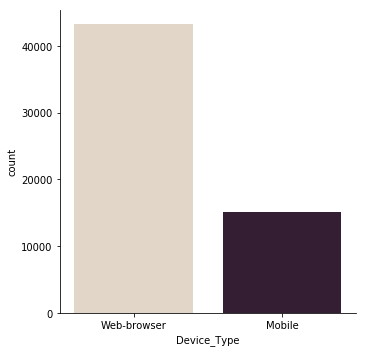

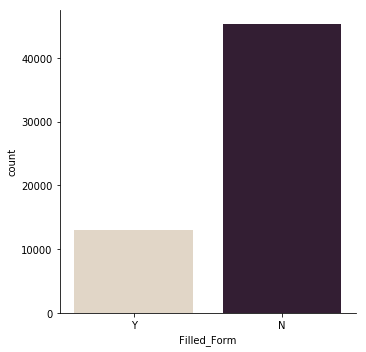

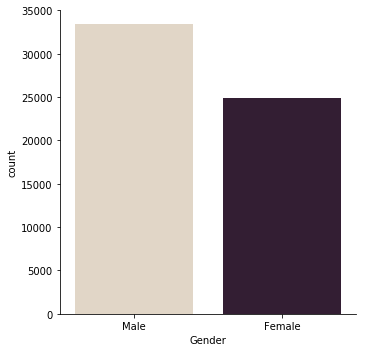

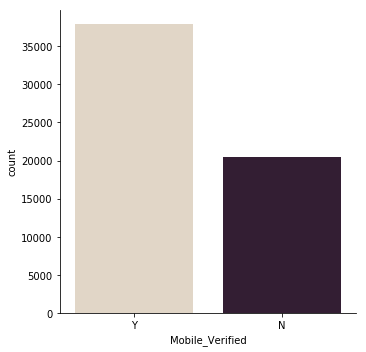

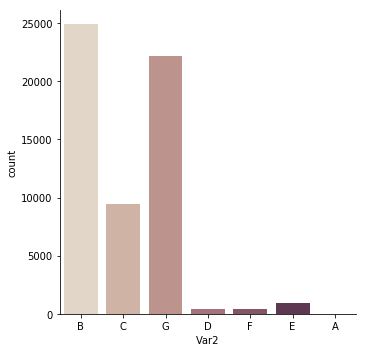

In [23]:
for var in VariablesStr.difference(['City','Var1','Source','Salary_Account']):
    sns.catplot(x=var, kind="count", palette="ch:.25", data=X_train)
    plt.show()

In [24]:
X_train['City'].value_counts()/len(X_train)

Delhi                  0.143783
Bengaluru              0.125122
Mumbai                 0.123561
Hyderabad              0.083924
Chennai                0.078984
Pune                   0.059500
Kolkata                0.033686
Ahmedabad              0.019776
Jaipur                 0.014956
Gurgaon                0.013739
Coimbatore             0.013361
Thane                  0.010548
Chandigarh             0.009897
Surat                  0.009605
Visakhapatnam          0.008850
Indore                 0.008199
Lucknow                0.007187
Vadodara               0.007169
Nagpur                 0.007084
Ghaziabad              0.006260
Bhopal                 0.006020
Patna                  0.005523
Kochi                  0.005489
Faridabad              0.005094
Noida                  0.004511
Madurai                0.004477
Gautam Buddha Nagar    0.003979
Dehradun               0.003482
Raipur                 0.003327
Bhubaneswar            0.003156
                         ...   
Sonepur 

In [25]:
X_train['Var1'].value_counts()/len(X_train)

HBXX    0.681389
HBXC    0.104454
HBXB    0.051112
HAXA    0.033274
HBXA    0.024150
HAXB    0.023172
HBXD    0.022452
HAXC    0.017718
HBXH    0.011372
HCXF    0.008250
HAYT    0.005866
HAVC    0.004391
HAXM    0.002967
HCXD    0.002796
HCYS    0.002367
HVYS    0.002041
HAZD    0.001132
HCXG    0.000892
HAXF    0.000206
Name: Var1, dtype: float64

In [26]:
X_train['Var2'].value_counts()/len(X_train)

B    0.427079
G    0.381078
C    0.162565
E    0.015317
D    0.007495
F    0.006432
A    0.000034
Name: Var2, dtype: float64

In [27]:
X_train['Salary_Account'].value_counts()/len(X_train)

HDFC Bank                                          0.204123
ICICI Bank                                         0.155858
State Bank of India                                0.136391
Axis Bank                                          0.101556
Citibank                                           0.026843
Kotak Bank                                         0.023721
IDBI Bank                                          0.017683
Punjab National Bank                               0.014202
Bank of India                                      0.013430
Bank of Baroda                                     0.012555
Canara Bank                                        0.011303
Standard Chartered Bank                            0.011286
Union Bank of India                                0.010583
Yes Bank                                           0.009211
ING Vysya                                          0.007598
Corporation bank                                   0.007512
Indian Overseas Bank                    

In [28]:
X_train['Source'].value_counts()/len(X_train)

S122    0.444986
S133    0.341595
S159    0.063770
S143    0.049706
S127    0.022126
S137    0.020256
S134    0.015128
S161    0.009125
S151    0.008353
S157    0.007444
S153    0.005832
S156    0.003533
S144    0.003482
S158    0.002350
S123    0.000652
S162    0.000515
S141    0.000515
S124    0.000206
S160    0.000189
S150    0.000069
S139    0.000051
S155    0.000034
S135    0.000017
S136    0.000017
S138    0.000017
S129    0.000017
S154    0.000017
Name: Source, dtype: float64

In [29]:
class ImputerLoansStr(TransformerMixin,BaseEstimator):
    
    def __init__(self,variables):
        self.variables=variables

            
    def fit(self,X):
        self.imput1=[]
        for var in self.variables:
            self.imput1.append([x for x in X[var].unique() if len(X[X[var]==x])/len(X)>=0.05])
        return self
            
    
    def transform(self,X):
        i=0
        for var in self.variables:
            X.loc[~X[var].isin(self.imput1[i]),var]='other'
            i=1+i
        return X

Tworze pipeline transformujący dane treningowe jak i testowe. W kolejnym kroku wykorzystuję pipeline. 

In [30]:
pipeline=FeatureUnion([
    ("branch1",make_pipeline(ColumnSelector(variables),
                             Outliers(low_boundary,upp_boundary,variables),
                            ImputerLoans(['Loan_Amount_Applied','Loan_Amount_Submitted']), 
                            SimpleImputer(strategy="median"),
                            StandardScaler())),
    ("branch2",make_pipeline(ColumnSelector(VariablesStr),
                             ImputerLoansStr(['Source','City','Var2','Salary_Account','Var1']),
                            OneHotEncoder(sparse=False,handle_unknown='ignore')))


])


In [50]:
X_train_copy=X_train.copy()
X_train_copy=pd.DataFrame(pipeline.fit_transform(X_train_copy))


In [51]:
X_test_copy=X_test.copy()
X_test_copy=pd.DataFrame(pipeline.transform(X_test_copy))

Po przekształceniu zmiennych sprawdzam testowo moc pojedynczych driverów za pomoca czynnika gini.

In [52]:
from sklearn.metrics import roc_auc_score
n=1
for var in X_train_copy.columns:

    AUC=roc_auc_score(y_train, X_train_copy[var])
    Result=pd.DataFrame([{"VAR":var,"AUC":AUC,"GINI":abs(2*AUC-1)}])
    if n==1:
        ResultGini=pd.DataFrame(Result)
    else:
        ResultGini=ResultGini.append(Result,sort=False)
    n=n+1

In [53]:
ResultGini

,AUC,GINI,VAR
0,0.792987,0.585974,0
0,0.606069,0.212138,1
0,0.561288,0.122575,2
0,0.615959,0.231919,3
0,0.746835,0.493670,4
0,0.627472,0.254944,5
0,0.506349,0.012698,6
0,0.356150,0.287699,7
0,0.522941,0.045883,8
0,0.540430,0.080860,9


Liczę model wykorzystując po kolei regresję logistyczną, drzewa decyzyjne, lasy losowe i XGBoost. Robie to oddzielnie, ponieważ GridSearchem szukam najoptymalniejszych parametrów dla każdego typu modelu. Ze względu na nierównomiernośc grup 0:1 zmieniam też wagę wartościom 1.

In [54]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

In [55]:

pipe = Pipeline([ ("model",LogisticRegression())])

param_grid = {"model__C":[0.1,1,10],
              "model__class_weight":[{0:1,1:5},{0:1,1:15},{0:1,1:25}],
              "model__penalty":["l1","l2"]
                 }

model_reg=GridSearchCV(pipe,param_grid,scoring='f1',cv=3)
model_reg.fit(X_train_copy,y_train)
model_reg.best_estimator_

Pipeline(memory=None,
     steps=[('model', LogisticRegression(C=0.1, class_weight={0: 1, 1: 15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [56]:
Accuracy_test_reg=accuracy_score(model_reg.best_estimator_.predict(X_test_copy),y_test)
Accuracy_train_reg=accuracy_score(model_reg.best_estimator_.predict(X_train_copy),y_train)
f1_reg=f1_score(y_test, model_reg.best_estimator_.predict(X_test_copy))
AUC_reg=roc_auc_score(y_true=y_test,y_score=model_reg.best_estimator_.predict_proba(X_test_copy)[:,1])
#True Positive
TP_reg = np.sum(np.logical_and(model_reg.best_estimator_.predict(X_test_copy) == 1, y_test == 1))
# True Negative 
TN_reg= np.sum(np.logical_and(model_reg.best_estimator_.predict(X_test_copy) == 0, y_test == 0))
# False Positive 
FP_reg = np.sum(np.logical_and(model_reg.best_estimator_.predict(X_test_copy) == 1, y_test == 0))
# False Negative 
FN_reg = np.sum(np.logical_and(model_reg.best_estimator_.predict(X_test_copy) == 0, y_test == 1))
 

In [57]:
param_grid = {"criterion":["gini","entropy"],
              "max_depth":[10,20,100],
              "min_samples_split":[5,10,50] ,
                "min_samples_leaf":[2,5,10],
             "class_weight":[{0:1,1:10},{0:1,1:25},{0:1,1:50}]}

model_dec_tree = GridSearchCV(DecisionTreeClassifier(),param_grid,scoring='f1',cv=3)
model_dec_tree.fit(X_train_copy,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 100], 'min_samples_split': [5, 10, 50], 'min_samples_leaf': [2, 5, 10], 'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 25}, {0: 1, 1: 50}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [58]:
Accuracy_test_dec_tree=accuracy_score(model_dec_tree.best_estimator_.predict(X_test_copy),y_test)
Accuracy_train_dec_tree=accuracy_score(model_dec_tree.best_estimator_.predict(X_train_copy),y_train)
f1_dec_tree=f1_score(y_test, model_dec_tree.best_estimator_.predict(X_test_copy))
AUC_dec_tree=roc_auc_score(y_true=y_test,y_score=model_dec_tree.best_estimator_.predict_proba(X_test_copy)[:,1])
#True Positive
TP_dec_tree = np.sum(np.logical_and(model_dec_tree.best_estimator_.predict(X_test_copy) == 1, y_test == 1))
# True Negative 
TN_dec_tree = np.sum(np.logical_and(model_dec_tree.best_estimator_.predict(X_test_copy) == 0, y_test == 0))
# False Positive 
FP_dec_tree = np.sum(np.logical_and(model_dec_tree.best_estimator_.predict(X_test_copy) == 1, y_test == 0))
# False Negative 
FN_dec_tree = np.sum(np.logical_and(model_dec_tree.best_estimator_.predict(X_test_copy) == 0, y_test == 1))
 


In [59]:
model_dec_tree.best_estimator_

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [60]:
param_grid = {"criterion":["gini","entropy"],
             "n_estimators":[2, 10, 20],
             "min_samples_split":[10,50] ,
             "min_samples_leaf":[5,10],
             "class_weight":[{0:1,1:5},{0:1,1:15},{0:1,1:25}]}

model_random_forest = GridSearchCV(RandomForestClassifier(),param_grid,scoring='f1',cv=3)
model_random_forest.fit(X_train_copy,y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [2, 10, 20], 'min_samples_split': [10, 50], 'min_samples_leaf': [5, 10], 'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 15}, {0: 1, 1: 25}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [61]:
model_random_forest.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [62]:
Accuracy_test_random_forest=accuracy_score(model_random_forest.best_estimator_.predict(X_test_copy),y_test)
Accuracy_train_random_forest=accuracy_score(model_random_forest.best_estimator_.predict(X_train_copy),y_train)
f1_random_forest=f1_score(y_test, model_random_forest.best_estimator_.predict(X_test_copy))
AUC_random_forest=roc_auc_score(y_true=y_test,y_score=model_random_forest.best_estimator_.predict_proba(X_test_copy)[:,1])
#True Positive
TP_random_forest = np.sum(np.logical_and(model_random_forest.best_estimator_.predict(X_test_copy) == 1, y_test == 1))
# True Negative 
TN_random_forest = np.sum(np.logical_and(model_random_forest.best_estimator_.predict(X_test_copy) == 0, y_test == 0))
# False Positive 
FP_random_forest = np.sum(np.logical_and(model_random_forest.best_estimator_.predict(X_test_copy) == 1, y_test == 0))
# False Negative 
FN_random_forest = np.sum(np.logical_and(model_random_forest.best_estimator_.predict(X_test_copy) == 0, y_test == 1))
 


In [63]:
param_grid =  {
        'min_child_weight': [3, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6,  1.0],
        'max_depth': [3, 5],
        'scale_pos_weight':[5,15,25]
        }

model_XGB = GridSearchCV(XGBClassifier(),param_grid,scoring='f1',cv=3)
model_XGB.fit(X_train_copy,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [3, 10], 'gamma': [0.5, 2, 5], 'subsample': [0.6, 1.0], 'colsample_bytree': [0.6, 1.0], 'max_depth': [3, 5], 'scale_pos_weight': [5, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [64]:
Accuracy_test_XGB=accuracy_score(model_XGB.best_estimator_.predict(X_test_copy),y_test)
Accuracy_train_XGB=accuracy_score(model_XGB.best_estimator_.predict(X_train_copy),y_train)
f1_XGB=f1_score(y_test, model_XGB.best_estimator_.predict(X_test_copy))
AUC_XGB=roc_auc_score(y_true=y_test,y_score=model_XGB.best_estimator_.predict_proba(X_test_copy)[:,1])
#True Positive
TP_XGB = np.sum(np.logical_and(model_XGB.best_estimator_.predict(X_test_copy) == 1, y_test == 1))
# True Negative 
TN_XGB = np.sum(np.logical_and(model_XGB.best_estimator_.predict(X_test_copy) == 0, y_test == 0))
# False Positive 
FP_XGB = np.sum(np.logical_and(model_XGB.best_estimator_.predict(X_test_copy) == 1, y_test == 0))
# False Negative 
FN_XGB = np.sum(np.logical_and(model_XGB.best_estimator_.predict(X_test_copy) == 0, y_test == 1))
 

In [65]:
model_XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=15, seed=None,
       silent=None, subsample=1.0, verbosity=1)

POrównuję wyniki modeli za pomoca statystyk AUC, ACCURACY czy F1.

In [66]:
Results=pd.DataFrame({'Accuracy test sample':[Accuracy_test_reg,Accuracy_test_dec_tree,Accuracy_test_random_forest,Accuracy_test_XGB],
                     'Accuracy train sample':[Accuracy_train_reg,Accuracy_train_dec_tree,Accuracy_train_random_forest,Accuracy_train_XGB],
                    'f1':[f1_reg,f1_dec_tree,f1_random_forest,f1_XGB],
                    'AUC':[AUC_reg,AUC_dec_tree,AUC_random_forest,AUC_XGB],
                    'True Positive':[TP_reg,TP_dec_tree,TP_random_forest,TP_XGB],
                    'True Negative':[TN_reg,TN_dec_tree,TN_random_forest,TN_XGB],
                    'False Positive':[FP_reg,FP_dec_tree,FP_random_forest,FP_XGB],
                    'False Negative':[FN_reg,FN_dec_tree,FN_random_forest,FN_XGB]})

In [67]:
Results.index=['Regression','DecisionTree','RandomForest','XGBoost']

In [68]:
Results

,Accuracy test sample,Accuracy train sample,f1,AUC,True Positive,True Negative,False Positive,False Negative
Regression,0.943587,0.946006,0.117647,0.810712,108,26989,1293,327
DecisionTree,0.960999,0.968887,0.080460,0.711702,49,27548,734,386
RandomForest,0.971620,0.982557,0.111232,0.812535,51,27851,431,384
XGBoost,0.961521,0.965182,0.141414,0.837444,91,27521,761,344


Patrząc na wyniki żaden z modeli nie charakteryzuje się wysoką moca predykcyjną.
Wydaje mi się, że może to być spowodowane treścią zadania, ponieważ
tak naprawdę najprawdopodobniej przewidujemy działanie innego modelu, na podstawie którego udzielano zaangazowań.
Nie szukamy najlepszych klientów, tylko tych wybranych w jakiś specyficzny sposób. Nie mniej jednak najlepszymi
modelami wydają się być XGBoost, regresja logistyczna oraz lasy losowe ze wskazaniem na XGBoost. Wysokie accuracy jest spowodowane
kształem próbki w związku z czym lepiej jest patrzyć np. na miarę F1 czy AUC.